In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [2]:
print(os.path.exists("variant1-mushrooms.csv"))

True


In [3]:
data = pd.read_csv("variant1-mushrooms.csv", encoding='latin1')

In [4]:
print(data.isnull().sum())

cap-diameter       0
cap-shape          0
gill-attachment    0
gill-color         0
stem-height        0
stem-width         0
stem-color         0
season             0
class              0
dtype: int64


In [5]:
print("Розмір даних:", data.shape)

Розмір даних: (54035, 9)


In [6]:
print('columns count - ',len(data.columns), '\n')
print('columns: ',list(data.columns))

columns count -  9 

columns:  ['cap-diameter', 'cap-shape', 'gill-attachment', 'gill-color', 'stem-height', 'stem-width', 'stem-color', 'season', 'class']


In [7]:
missing = list()
for x in data.columns:
    if data[x].isnull().sum() != 0:
        print(data, data[x].isnull().sum())
        missing.append(x)
    else:
        print (x + " dont have null data!")

cap-diameter dont have null data!
cap-shape dont have null data!
gill-attachment dont have null data!
gill-color dont have null data!
stem-height dont have null data!
stem-width dont have null data!
stem-color dont have null data!
season dont have null data!
class dont have null data!


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54035 entries, 0 to 54034
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap-diameter     54035 non-null  int64  
 1   cap-shape        54035 non-null  int64  
 2   gill-attachment  54035 non-null  int64  
 3   gill-color       54035 non-null  int64  
 4   stem-height      54035 non-null  float64
 5   stem-width       54035 non-null  int64  
 6   stem-color       54035 non-null  int64  
 7   season           54035 non-null  float64
 8   class            54035 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 3.7 MB


In [9]:
# Drop the ID column and separate features and target
X = data.drop(columns=['class']).values 
y = data['class'].values

In [10]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
data.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


In [12]:
# Standardize the feature values for better training performance
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test)) 

In [13]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32) # Training features as a tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # Training labels as a tensor
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32) # Testing features as a tensor
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) # Testing labels as a tensor

In [14]:
# Define a simple Multi-Layer Perceptron (MLP) for binary classification
class BinaryClassificationMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
      super(BinaryClassificationMLP, self).__init__()
      self.hidden_layer = nn.Linear(input_size, hidden_size) # First layer (input to hidden)
      self.output_layer = nn.Linear(hidden_size, output_size) # Second layer (hidden to output)
      self.relu = nn.ReLU() # ReLU activation function for hidden layer
      self.sigmoid = nn.Sigmoid() # Sigmoid activation for output layer
    def forward(self, x):
      x = self.hidden_layer(x) # Linear transformation for the hidden layer
      x = self.relu(x) # Apply ReLU activation
      x = self.output_layer(x) # Linear transformation for the output layer
      x = self.sigmoid(x) # Apply sigmoid activation for binary classification
      return x

In [15]:
# Set hyperparameters
input_size = X_train.shape[1] # Number of features in the dataset
hidden_size = 22 # Number of neurons in the hidden layer
output_size = 1 # Binary classification output
learning_rate = 0.1 # Learning rate for the optimizer
num_epochs = 10 # Number of epochs to train the model

In [16]:
# Initialize the model, loss function, and optimizer
model = BinaryClassificationMLP(input_size, hidden_size, output_size) # Create the model instance
criterion = nn.BCELoss() # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam 
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
)

In [17]:
# Metrics and logging
losses = []
accuracies = []

In [18]:
# Training loop
model.train() # Set the model to training mode
for epoch in range(num_epochs):
 # Forward pass: compute predictions
 outputs = model(X_train_tensor)
 # Compute the loss between predictions and actual labels
 loss = criterion(outputs, y_train_tensor)
 losses.append(loss.item())
 # Convert predictions to binary values (0 or 1)
 predictions = (outputs.detach().numpy() > 0.5).astype(int)
 y_train_numpy = y_train_tensor.numpy()
 accuracy = accuracy_score(y_train_numpy, predictions)
 accuracies.append(accuracy)
 # Backward pass: compute gradients and update weights
 optimizer.zero_grad() # Clear previous gradients
 loss.backward() # Compute gradients
 optimizer.step() # Update weights based on gradients
 # Print loss and accuracy every 100 epochs for monitoring
 if (epoch + 1) % 50 == 0:
   print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy * 100:.2f}%')


In [19]:
# Evaluate the model on the test dataset
model.eval() # Set the model to evaluation mode

with torch.no_grad(): # Disable gradient computation for evaluation
    outputs = model(X_test_tensor) # Compute predictions
    test_loss = criterion(outputs, y_test_tensor) # Compute the loss for the test set

In [20]:
# Convert predictions to binary values (0 or 1)
test_predictions = (outputs.numpy() > 0.5).astype(int)
y_test_numpy = y_test_tensor.numpy()

In [21]:
# Compute metrics
test_accuracy = accuracy_score(y_test_numpy, test_predictions)
print(f'Test Loss: {test_loss.item():.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Loss: 0.5787
Test Accuracy: 69.63%


In [22]:
# Generate a classification report
print(classification_report(y_test_numpy, test_predictions, 
target_names=["Class 0", "Class 1"]))

              precision    recall  f1-score   support

     Class 0       0.66      0.67      0.67      4909
     Class 1       0.72      0.72      0.72      5898

    accuracy                           0.70     10807
   macro avg       0.69      0.69      0.69     10807
weighted avg       0.70      0.70      0.70     10807



In [23]:
# Compute ROC curve and AUC
y_probabilities = outputs.numpy() # Get predicted probabilities
fpr, tpr, _ = roc_curve(y_test_numpy, y_probabilities)
roc_auc = auc(fpr, tpr)

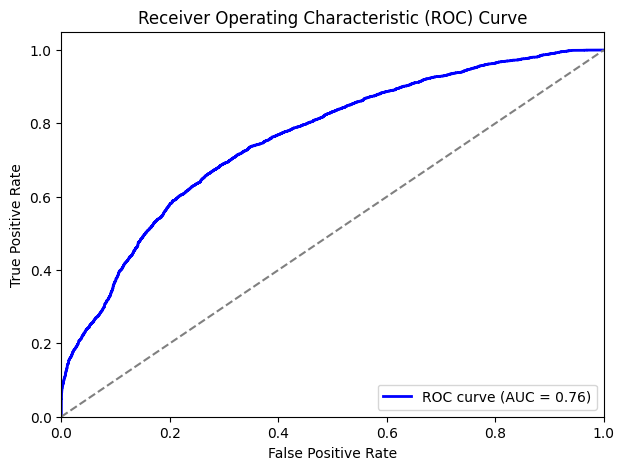

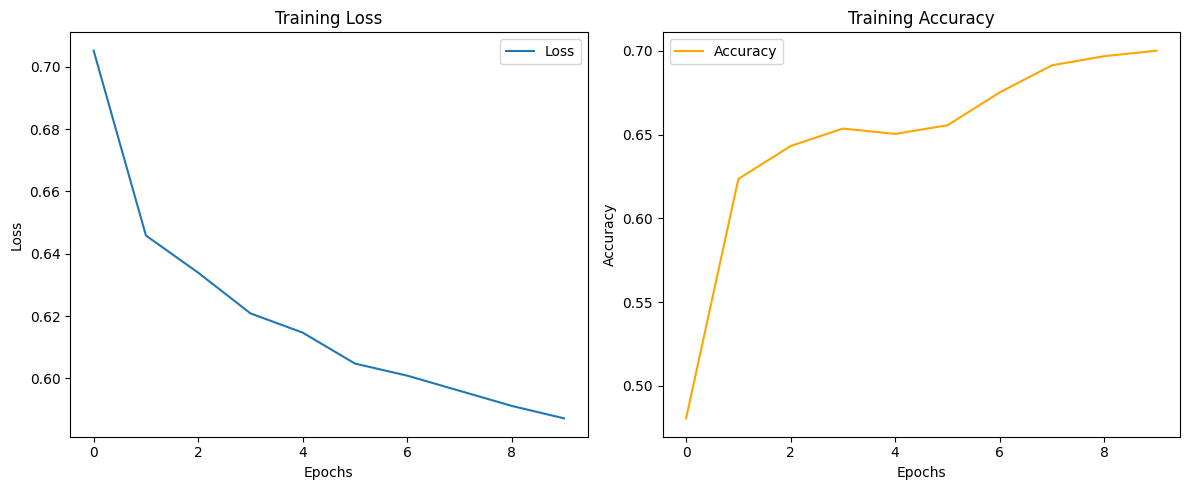

In [24]:
# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(len(losses)), losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracies)), accuracies, label='Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

|  № | Нейронів у прих. шарі | Learning rate | Epochs | Test Accuracy | F1-score |  ROC AUC |  Loss |
| -: | :-------------------: | :-----------: | :----: | :-----------: | :------: | :------: | :---: |
|  1 |           5           |     0.001     |   100  |   **63.74%**  |  \~0.64  | **0.69** | 0.653 |
|  2 |           22          |      0.1      |   10   |   **68.68%**  |  \~0.69  | **0.76** | 0.579 |
|  3 |           45          |      0.01     |  1000  |   **96.00%**  |  \~0.96  | **0.99** | 0.112 |
